데이터를 라벨링해서 광고 classification modeling 할 수 있도록

In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset

# JSON 파일 읽기
def load_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

json_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/CODE/사출성형/Preprocessing_data/Blog/KOREAN/blog_naver_preprocessed.json"

json_data = load_json(json_path)
# 데이터 프레임 생성
df = pd.DataFrame(json_data)
df['text'] = df['contents'].apply(lambda x: x['text'])
df['label'] = df['advertisement'].apply(lambda x: 1 if x == "TRUE" else 0)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

/anaconda/envs/llm-rag-embeddings/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from transformers import BertTokenizer
import torch

# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base")

# 토크나이저 함수 정의
def tokenize_data(texts, labels, tokenizer, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    #labels = torch.tensor(labels)
    labels = torch.tensor(labels.values) 

    return input_ids, attention_masks, labels

# 학습 및 테스트 데이터 토크나이징
X_train_ids, X_train_masks, y_train_tensor = tokenize_data(X_train, y_train, tokenizer)
X_test_ids, X_test_masks, y_test_tensor = tokenize_data(X_test, y_test, tokenizer)

In [6]:
# 데이터 로더 준비

batch_size = 16

train_dataset = TensorDataset(X_train_ids, X_train_masks, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_ids, X_test_masks, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# 모델 구축 및 학습
from transformers import BertForSequenceClassification

# BERT 모델 로드
model = BertForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=2)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)

# GPU 사용 설정 (가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/llm-rag-embeddings/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
# 학습 함수 정의
def train_model(model, train_dataloader, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

# 모델 학습
train_model(model, train_dataloader, optimizer, device)


Epoch 1/10, Loss: 0.019439411039153736
Epoch 2/10, Loss: 0.014116475358605385
Epoch 3/10, Loss: 0.009192390056947866
Epoch 4/10, Loss: 0.007614761435737212
Epoch 5/10, Loss: 0.005610703645894925
Epoch 6/10, Loss: 0.0050727858518560725
Epoch 7/10, Loss: 0.004381177946925163
Epoch 8/10, Loss: 0.003605213947594166
Epoch 9/10, Loss: 0.0032880941095451512
Epoch 10/10, Loss: 0.0029936484837283692


Accuracy: 84.62%
Precision: [0.85714286 0.83333333]
Recall: [0.85714286 0.83333333]
F1-score: [0.85714286 0.83333333]


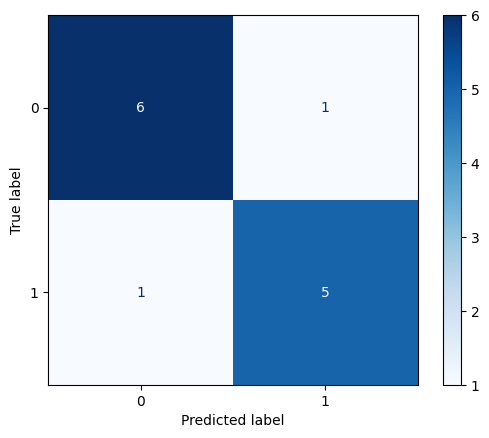


Misclassified Samples:
Text: 우진플라임의 전동식 사출성형기 사출부 TE - G5 고강성 인라인 사출장치 사출하우징과 사출 볼스크류부 장치 부분을 하나의 부품 ( 주물 ) 으로 구성됩니다. 사출 베드 및 계량부 LM 가이드 적용합니다. 2. 스크류 피치와 길이 ( L / D : 20 / 1 에서 22 / 1 ) 향상된 가소화능력으로 빠르고 균일한 수지응용 및 쿠션 편차 비율 감소합니다. 3. 듀얼 풀 노즐터치 실린더 반복적인.
Actual Label: 0, Predicted Label: 1

Text: 추출은 자동화된 기계나 작업자가 하며 제품이 사출기에서 제거된 후, 추가적인 작업이 필요한 경우도 있습니다 ~! 오늘 소개해 드릴 제품은 160 / 170톤의 사출 성형기로 400g 이하의 제품을 생산할 수 있습니다. 고온과 냉각이 반복되며 지속적인 작업을 수행할 경우, 어떤 기계는 발열이 심해져 자칫하면 화재가 발생할 수 있는 위험성이 있습니다. 하지만 이 플라스틱.
Actual Label: 1, Predicted Label: 0



In [15]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 평가 함수 정의 (잘못 예측된 데이터 식별 포함)
def evaluate_model(model, test_dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    misclassified_samples = []  # 잘못 예측된 데이터 저장

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            _, predicted = torch.max(logits, dim=1)
            
            total += b_labels.size(0)
            correct += (predicted == b_labels).sum().item()
            
            all_labels.extend(b_labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # 잘못 예측된 데이터 식별
            for i in range(len(b_labels)):
                if predicted[i] != b_labels[i]:
                    misclassified_samples.append({
                        'input_ids': b_input_ids[i].cpu().numpy(),
                        'attention_mask': b_input_mask[i].cpu().numpy(),
                        'label': b_labels[i].item(),
                        'prediction': predicted[i].item()
                    })

    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    # 잘못 예측된 데이터 출력
    print("\nMisclassified Samples:")
    for sample in misclassified_samples:
        input_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
        print(f"Text: {input_text}")
        print(f"Actual Label: {sample['label']}, Predicted Label: {sample['prediction']}\n")

# 모델 평가
evaluate_model(model, test_dataloader, device)


# 예측 TESTING

In [14]:
import json
import torch
from transformers import BertTokenizer

def predict_advertisement(model, tokenizer, text, device, max_length=256):
    model.eval()
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)
        
    return 'TRUE' if predicted.item() == 1 else 'FALSE'

# 새 JSON 데이터
new_data = {
    "ID": 59,
    "advertisement": "TRUE",
    "contents": {
        "title": "나주공장경매 나주시 왕곡면 덕산리 공장용지2426평 최저가48억 플라스틱",
        "text": "오늘 소개하는 전라남도 나주시 왕곡면 덕산리에 소재하는 공장은 포장용 플라스틱 성형용기 제조, 금형플라스틱사출성형, 프레스가공 공장은 나주공장경매 나주시 왕곡면 덕산리 공장용지2426평 일반공업지역 최저가48억 플라스틱 제조공장에 대한 자세한 내용은 부동산전문 법률사무소 담당자에게 문의주시면 친절하게."
    },
    "link": "https://goodauction.tistory.com/413",
    "source": "naver_blog",
    "date": "2024-04-02 16:16:58",
    "language": "korean"
}

# 예측 실행
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
tokenizer = BertTokenizer.from_pretrained('beomi/kcbert-base')
text = new_data['contents']['text']
prediction = predict_advertisement(model, tokenizer, text, device)
print(f'Predicted advertisement: {prediction}')


Predicted advertisement: TRUE


/anaconda/envs/llm-rag-embeddings/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
